In [1]:
import yaml
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import pandas as pd
import numpy as np

In [2]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)
from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import data_files
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


/home/yoyoteng/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
import os,sys
root_path = os.path.dirname(os.path.dirname(os.path.abspath('run.py')))
sys.path.append(root_path)

from cfg import cfg
from numerapi.numerapi import NumerAPI
import models
from data_utils import get_data_era_balanced,data_files,get_data, write_to_csv
import opt

model_list = [
    ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
    ('aec',models.aec.AecModel,dict(istrain=False)),
    ('xg',models.xg.XgModel,dict(istrain=False)),
    ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
    #('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)),
    #('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
]

In [4]:
X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
(354192, 50) (354192,) (39421, 50) (39421,)


In [ ]:
aec=models.aec.AecModel()
aec.load()
adv=models.aec_gan.AecAdvModel()
adv.load()
adx=models.aec_gan_xg.AecGanXgModel()
adx.load()

In [ ]:
for x in [X_train,X_val,X_test]:
    aecdX = aec.decoder.predict(x)
    advdX = adv.decoder.predict(x)
    adxdX = adx.aa_inst.decoder.predict(x)
    print('---------')
    print('aec',metrics.mean_squared_error(aecdX,x))
    print('adv',metrics.mean_squared_error(advdX,x))
    print('adx',metrics.mean_squared_error(adxdX,x))

In [11]:
import imp
imp.reload(models)
model_list = [
#     ('aecgan',models.aec_gan.AecAdvModel,dict(istrain=False)),
#     ('aec',models.aec.AecModel,dict(istrain=False)),
#     ('xg',models.xg.XgModel,dict(istrain=False)),
#     ('aecganxg',models.aec_gan_xg.AecGanXgModel,dict(istrain=False)),# depends on model from AecAdvModel
#     ('aecgs',models.aec_gan_stack.AecAdvStackModel,dict(istrain=False)), # depends on model from AecAdvModel
#     ('ganmore',models.ganmore.GanMoreModel,dict(istrain=False)),
#     ('disentangle',models.disentangle.DisentangleModel,dict(istrain=False)),
#     ('disentanglegan',models.disentanglegan.DisentangleGanModel,dict(istrain=False)),
#     ('idg',models.icadisengan.IcaDisentangleGanModel,dict(istrain=False)),
    ('mdg',models.moddisengan.DisentangleModel,dict(istrain=True)),
]

In [12]:
val_inds = np.array(np.where(_datatypes=='validation')).squeeze()

In [13]:
val_inds.shape

(46362,)

In [14]:
def to_int(e):
    try:
        return int(e.strip('era'))
    except:
        return float('nan')
ll_list = []
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    val_eras = sorted([x for x in np.unique(eras__) if x not in ['eraX']])
    ll={}
    for name,clsf,params in model_list:
        inst = clsf()
        inst.load()
        y_pred,_ = inst.predict(X__)
        ll[name]=[]
        for era in val_eras:
            inds = np.array(np.where(eras__==era)).squeeze()
            l = opt.log_loss_func([1.],[y_pred[inds]],y__[inds])
            ll[name].append({'eras':to_int(era),'log_loss':l})
        ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))
# https://github.com/numerai/submission-criteria/blob/daac1970a984cd4392c720771d3c5c4bcb9de1d4/submission_criteria/database_manager.py#L71 

trainpath mdg cons:0.5917 logloss:0.6929
testpath mdg cons:0.8333 logloss:0.6927


In [15]:
# logloss aecgan 0.693058273797
# logloss aec 0.692759657592
# logloss xg 0.693008686052
# logloss aecganxg 0.692780967413

In [16]:
m_list = ['mdg']
for mn in m_list:
    dn=np.sum(ll_list[0][mn].log_loss < -np.log(0.5))
    nu=ll_list[0][mn].log_loss.shape[0]
    print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
    dn=np.sum(ll_list[1][mn].log_loss < -np.log(0.5))
    nu=ll_list[1][mn].log_loss.shape[0]
    print('{:1.4f} {} {}'.format(dn/float(nu),dn,nu))
    print('--')

0.5917 71 120
0.8333 10 12
--


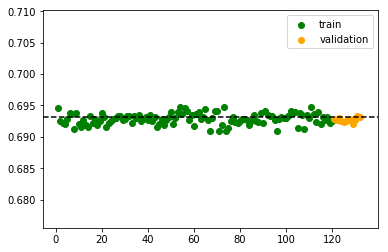

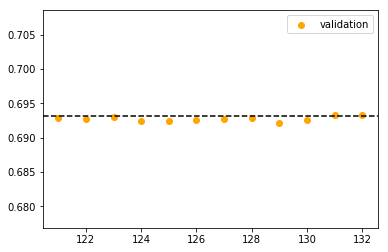

In [17]:
#mn = 'idg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
mn = 'aecganxg'
plt.figure(0)
plt.scatter(ll_list[0][mn].eras,ll_list[0][mn].log_loss,label='train',color='green')
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')
plt.figure(1)
plt.scatter(ll_list[1][mn].eras,ll_list[1][mn].log_loss,label='validation',color='orange')
plt.legend()
plt.axhline(y=-np.log(0.5), xmin=0, xmax=1,color='k',linestyle='--')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

#X_test,y_test,ids,_eras,_datatypes=get_data(data_files[-1]['testpath'])
#X_train,y_train,X_val,y_val = get_data_era_balanced(data_files[-1]['trainpath'])

# Score on the training set was:0.6049871246781169
# exported_pipeline = make_pipeline(
#     FastICA(tol=0.35000000000000003),
#     StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=14, n_estimators=100)),
#     ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=17, min_samples_split=13, n_estimators=100)
# )
args = [
    FastICA(tol=0.35000000000000003),
    StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.1, min_samples_leaf=3, min_samples_split=7, n_estimators=100)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=, min_samples_split=6, n_estimators=80),

]
exported_pipeline = make_pipeline(
    *args,
    memory=memory
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


import pickle
with open('mymodel','wb') as f:
    pickle.dump(model,f)

In [ ]:
for p in ['trainpath','testpath']:
    X__,y__,ids__,eras__,datatypes__=get_data(data_files[-1][p])
    results = exported_pipeline.predict_proba(X__)
    val_eras = [x for x in np.unique(eras__) if x not in ['eraX']]
    ll = {}
    name = 'tpot'
    ll[name]=[]
    for era in val_eras:
        inds = np.array(np.where(eras__==era)).squeeze()
        l = opt.log_loss_func([1.],[results[inds]],y__[inds])
        ll[name].append({'eras':to_int(era),'log_loss':l})
    ll[name] = pd.DataFrame(ll[name])
    ll_list.append(ll)
    for k in sorted(ll.keys()):
        v = ll[k].log_loss
        consistency = np.sum(v<-np.log(0.5))/len(v)
        mila = np.mean(v)
        print('{} {} cons:{:1.4f} logloss:{:1.4f}'.format(p,k,consistency,mila))


In [ ]:
opt_weights = opt.opt_weights(y_pred_list,y_test[val_inds])

In [ ]:
opt_pred = opt.opt_pred(y_pred_list,opt_weights)
print(len(y_pred_list),opt_weights.shape,opt_pred.shape)
print('final logloss',name,opt.log_loss_func([1.0],[opt_pred],y_test[val_inds]))

In [ ]:
print(['{:.8f}'.format(x) for x in opt_weights])
print(np.sum(opt_weights))